In [1]:
############### LOADING DATA ###############

%run '/home/christianl/Zhang-Lab/Zhang Lab Code/Boilerplate_datahandling/Remote boilerplate/model_load.py'

Loading pre-computed predictions...
✓ Loaded predictions for 3 models
  Training samples: 12748, Genes: 16100
  Test samples: 3187, Genes: 16100

✓ All functions loaded. Ready for analysis!


In [ ]:
############### UNIT TEST ###############

# Check what your y_test columns actually are:
print("y_test columns type:", type(y_test.columns))
print("First 5 column names:", y_test.columns[:5].tolist())

# Also check if y_test is actually a DataFrame or numpy array:
print("y_test type:", type(y_test))

y_test columns type: <class 'pandas.core.indexes.base.Index'>
First 5 column names: ['A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'AAAS']
y_test type: <class 'pandas.core.frame.DataFrame'>


In [ ]:
############### UNIT TEST ###############

import inspect
print(inspect.getsource(compute_metrics_per_gene_test))

def compute_metrics_per_gene_test(y_true_df, y_pred_array):
    """Compute per-gene metrics."""
    n_genes = y_true_df.shape[1]
    results = []
    
    for i, gene_name in enumerate(y_true_df.columns):
        y_t = y_true_df.iloc[:, i].values
        y_p = y_pred_array[:, i]
        
        if np.var(y_t) > 1e-10:
            pearson_r, p_value = pearsonr(y_t, y_p)
            r2 = r2_score(y_t, y_p)
            
            results.append({
                'gene': gene_name,
                'gene_idx': i,
                'r2': r2,
                'pearson_r': pearson_r,
                'p_value': p_value
            })
    
    return pd.DataFrame(results)



In [ ]:
############### DIAGNOSTICS ###############

# diagnostics of MLR r2 scores

# checking to ensure predictions and groundtruth are comparable (they do)
assert y_test.shape == mlr_y_pred.shape

# compare r2 values
# .score() r2 is the variance-weighted r2, which computes each gene's r2 individually (genes are treated differently) 
# as each gene predictions are still in 2D Numpy arrays not flattened
# mlr_loaded.score: 0.7986089431408789
print("mlr_loaded.score:", mlr_loaded.score(x_test, y_test))

# compute_metrics() is the flattened r2, where each gene's r2 is treated equally (flattened) before aggregating
# compute_metrics r2: 0.9323357932034118

# compute_metrics r2 > .score() r2 -> figured out that .score() when unspecified does uniform-average, different to compute_metrics r2 
# which calculates the variance-weighted r2, taking into account the individual variances of each gene.
# given the difference of 0.365 between the two, positive correlation between variance and R2 indicates that model performs better
# on genes with higher variance (more distinct expression patterns) than lower variance ones (ie. housekeeping, "silenced", etc.)

metrics_flat_mlr = compute_metrics(y_test.values, mlr_y_pred)
print("compute global R²:", metrics_flat_mlr['r2'])

# compute_metrics_per_gene() looks at the indiviudal r2 at per-gene resolution (using DFs to maintain biological relevance of each column) 

#compute_metrics_per_gene r2: 0        0.861767
#1        0.747973
#2        0.373796
#3        0.769920
#4        0.859807
#           ...   
#16095    0.736619
#16096    0.866326
#16097    0.924248
#16098    0.912513
#16099    0.900036
#Name: r2, Length: 16100, dtype: float64

metrics_flat_per_gene_mlr = compute_metrics_per_gene_test(y_test, mlr_y_pred)
print("compute_metrics_per_gene R²:", metrics_flat_per_gene_mlr['r2'])

y_test shape: (3187, 16100)
y_pred_mlr shape: (3187, 16100)
mlr_loaded.score: 0.7986089431408789
compute_metrics r2: 0.9323357932034118
compute_metrics_per_gene r2: 0        0.861767
1        0.747973
2        0.373796
3        0.769920
4        0.859807
           ...   
16095    0.736619
16096    0.866326
16097    0.924248
16098    0.912513
16099    0.900036
Name: r2, Length: 16100, dtype: float64


In [ ]:
############### DIAGNOSTICS ###############

# same diagnostics for XGBRF.v3 (trained on same x_train)
# checking to ensure predictions and groundtruth are comparable
assert y_test.shape == xgbrf_y_pred.shape

# computing XGBRF metrics (aggregate and per gene (per model is this case))
# compute global R²: 0.9136
metrics_flat_xgbrf = compute_metrics(y_test.values, xgbrf_y_pred)
print(f"compute global R²: {metrics_flat_xgbrf['r2']:.4f}")

#compute_metrics_per_gene R²: 0        0.798614
#1        0.732539
#2        0.390864
#3        0.717345
#4        0.819955
#           ...   
#16095    0.677608
#16096    0.801420
#16097    0.883455
#16098    0.861673
#16099    0.863954
#Name: r2, Length: 16100, dtype: float64

metrics_flat_per_gene_xgbrf = compute_metrics_per_gene_test(y_test, xgbrf_y_pred)
print("compute_metrics_per_gene R²:", metrics_flat_per_gene_xgbrf['r2'])


compute global R²: 0.9136


In [ ]:
############### DIAGNOSTICS ###############


# same diagnostics for RNN.v1 (used as a reference for data preprocessing of other models )
# checking to ensure predictions and groundtruth are comparable
assert y_test.shape == rnn_y_pred.shape

# computing RNN metrics (aggregate and per gene (per model is this case))
# compute global R²: 0.7366
metrics_flat_rnn = compute_metrics(y_test.values, rnn_y_pred)
print(f"compute global R²: {metrics_flat_rnn['r2']:.4f}")

#compute_metrics_per_gene R²: 0        0.249111
#1       -0.058234
#2       -0.235948
#3        0.382344
#4        0.671084
#           ...   
#16095    0.336766
#16096    0.509802
#16097    0.657901
#16098    0.514623
#16099    0.622254
#Name: r2, Length: 16100, dtype: float64

metrics_flat_per_gene_rnn = compute_metrics_per_gene_test(y_test, rnn_y_pred)
print("compute_metrics_per_gene R²:", metrics_flat_per_gene_rnn['r2'])

# lower R² than I would have expected - maybe the test-train splitting was different for model training? 21/01/26

compute global R²: 0.7366


In [8]:
############### PLOTTING FUNCTION ###############

def figure_1_observed_vs_predicted(y_true, predictions_dict, 
                                  r2_method='variance_weighted',
                                  output_path='~/Zhang-Lab/Zhang Lab Data/Saved figures/'):
    """
    Generate observed vs. predicted scatterplot with Pearson correlation, R2, RMSE and MAE.
    """
    set_publication_style()
    fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_TRIPLE)
    model_names = list(predictions_dict.keys())
    
    for idx, model_name in enumerate(model_names):
        ax = axes[idx]
        y_pred = predictions_dict[model_name]
        
        # Flatten arrays for scatter plot
        y_true_flat = np.asarray(y_true).ravel()
        y_pred_flat = np.asarray(y_pred).ravel()
        
        # Compute metrics based on specified method
        if r2_method == 'variance_weighted' or r2_method == 'flattened':
            r2 = r2_score(y_true_flat, y_pred_flat)
            r2_label = "R² (var-w)" # Shortened for display fit
        elif r2_method == 'uniform_average':
            r2 = r2_score(y_true, y_pred, multioutput='uniform_average')
            r2_label = "R² (uni-avg)"
        else:
            raise ValueError(f"Unknown r2_method: {r2_method}")
        
        # Pearson correlation
        pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)

        # --- NEW: Calculate RMSE and MAE for the plot ---
        rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        
        # Scatter plot
        ax.scatter(y_true_flat, y_pred_flat, alpha=0.5, s=5, 
                   color=MODEL_COLORS.get(model_name, '#1f77b4'),
                   edgecolors='none')
        
        # Perfect prediction diagonal line
        min_val = min(y_true_flat.min(), y_pred_flat.min())
        max_val = max(y_true_flat.max(), y_pred_flat.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', 
                lw=1, alpha=0.5, label='Perfect prediction')
        
        # Fit regression line
        z = np.polyfit(y_true_flat, y_pred_flat, 1)
        p = np.poly1d(z)
        x_line = np.linspace(y_true_flat.min(), y_true_flat.max(), 100)
        y_line = p(x_line)
        ax.plot(x_line, y_line, color="#000000",
                lw=1.5, alpha=0.8, label='Linear fit')
        
        # Labels and formatting
        ax.set_xlabel('Observed Expression (Log10)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Predicted Expression (Log10)', fontsize=12, fontweight='bold')
        ax.set_title(model_name, fontsize=13, fontweight='bold')
        
        # --- MODIFIED: Add RMSE and MAE to text box ---
        # Construct the string part by part for clarity
        stats_text = (f"Pearson's R = {pearson_r:.4f}\n"
                      f"{r2_label} = {r2:.4f}\n"
                      f"RMSE = {rmse:.4f}\n"
                      f"MAE = {mae:.4f}")
        
        # Append p-value logic
        if p_value < 0.001:
            textstr = f"{stats_text}\np < 0.001"
        else:
            textstr = f"{stats_text}\np = {p_value:.3f}"
        
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        ax.set_xlim(-8, 6)
        ax.set_ylim(-8, 6)
    
    # counting how many points are within visible range
    for idx, model_name in enumerate(model_names):
        ax = axes[idx]
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
    
        y_pred = predictions_dict[model_name]
        y_true_flat = np.asarray(y_true).ravel()
        y_pred_flat = np.asarray(y_pred).ravel()
    
        outside_x = ((y_true_flat < xlim[0]) | (y_true_flat > xlim[1])).sum()
        outside_y = ((y_pred_flat < ylim[0]) | (y_pred_flat > ylim[1])).sum()
        
        print(f"\n{model_name}:")
        print(f"  Axis limits: x={xlim}, y={ylim}")
        print(f"  Points outside x-range: {outside_x}")
        print(f"  Points outside y-range: {outside_y}")
        print(f"  Data range: x=[{y_true_flat.min():.2f}, {y_true_flat.max():.2f}], y=[{y_pred_flat.min():.2f}, {y_pred_flat.max():.2f}]")
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
    print(f"Figure 1 saved to {output_path}")
    plt.show()
    
    # Return metrics for reference
    metrics_summary = {}
    for model_name in model_names:
        y_pred = predictions_dict[model_name]
        y_true_flat = np.asarray(y_true).ravel()
        y_pred_flat = np.asarray(y_pred).ravel()
        
        pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
        r2_variance_weighted = r2_score(y_true_flat, y_pred_flat)
        r2_uniform = r2_score(y_true, y_pred, multioutput='uniform_average')
        rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        
        metrics_summary[model_name] = {
            'pearson_r': pearson_r,
            'p_value': p_value,
            'r2_variance_weighted': r2_variance_weighted,
            'r2_uniform_average': r2_uniform,
            'rmse': rmse,
            'mae': mae
        }
    
    return metrics_summary

In [ ]:
############### UNIT TEST ###############

# How many MLR predictions are in the "visible" range of your plot (roughly 0-7)?
visible_range = (mlr_y_pred >= -1) & (mlr_y_pred <= 7)
print(f"MLR predictions in visible range: {visible_range.sum()} / {mlr_y_pred.size}")
print(f"Percentage visible: {100 * visible_range.sum() / mlr_y_pred.size:.2f}%")

MLR predictions in visible range: 51302506 / 51310700
Percentage visible: 99.98%


In [29]:
############### UNIT TEST ###############

print("Prediction variance:")
for model_name, y_pred in predictions.items():
    print(f"{model_name}: {y_pred.std():.4f}")

Prediction variance:
MLR: 0.6675
XGBRFRegressor: 0.6424
RNN: 0.5723


In [ ]:
############### UNIT TEST ###############

# Huge outlier range for MLR, so auto-scaling is such that the datpoints are super compressed
# to accomodate the rare ouliers (99.98% data within a normal 0-6 range like other plots)

# This is yet another reason MLR isn't a good choice for gene expression prediction tasks compared 
# to other models suitable for handling this data's non-linearity

print("Prediction ranges:")
for model_name, y_pred in predictions.items():
    pred_range = y_pred.max() - y_pred.min()
    print(f"{model_name}: {pred_range:.4f}")

Prediction ranges:
MLR: 15.0020
XGBRFRegressor: 5.5158
RNN: 5.3091


In [3]:
############### UNIT TEST ###############

def test_figure_1_predictions(y_true, predictions_dict):
    """
    Comprehensive sanity checks for prediction plots.
    
    Returns dict of test results with PASS/FAIL for each check.
    """
    tests = {}
    
    # ===== TEST 1: Shape consistency =====
    n_samples, n_genes = y_true.shape
    
    for model_name, y_pred in predictions_dict.items():
        # Check shapes match
        shape_match = y_pred.shape == y_true.shape
        tests[f'{model_name}_shape_match'] = 'PASS' if shape_match else f'FAIL: {y_pred.shape} != {y_true.shape}'
        
        # Check for NaNs
        has_nan = np.isnan(y_pred).any()
        tests[f'{model_name}_no_nans'] = 'FAIL: Contains NaN' if has_nan else 'PASS'
        
        # Check for Infs
        has_inf = np.isinf(y_pred).any()
        tests[f'{model_name}_no_infs'] = 'FAIL: Contains Inf' if has_inf else 'PASS'
    
    # ===== TEST 2: Data range sanity =====
    y_true_flat = y_true.ravel()
    
    for model_name, y_pred in predictions_dict.items():
        y_pred_flat = y_pred.ravel()
        
        # Check if predictions are in reasonable range of true values
        y_true_range = (y_true_flat.min(), y_true_flat.max())
        y_pred_range = (y_pred_flat.min(), y_pred_flat.max())
        
        # Predictions shouldn't exceed true range by more than 50%
        range_width_true = y_true_range[1] - y_true_range[0]
        range_width_pred = y_pred_range[1] - y_pred_range[0]
        
        reasonable_range = range_width_pred < (range_width_true * 1.5)
        tests[f'{model_name}_reasonable_range'] = 'PASS' if reasonable_range else \
            f'FAIL: pred range {range_width_pred:.2f} vs true range {range_width_true:.2f}'
        
        # Check if prediction distribution is similar to true distribution
        pred_mean = y_pred_flat.mean()
        true_mean = y_true_flat.mean()
        mean_diff = abs(pred_mean - true_mean)
        
        reasonable_mean = mean_diff < (abs(true_mean) * 0.5)  # Within 50% of true mean
        tests[f'{model_name}_reasonable_mean'] = 'PASS' if reasonable_mean else \
            f'FAIL: pred mean {pred_mean:.2f} vs true mean {true_mean:.2f}'
    
    # ===== TEST 3: Performance sanity =====
    for model_name, y_pred in predictions_dict.items():
        y_pred_flat = y_pred.ravel()
        
        # Pearson R should be positive and significant
        pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
        
        tests[f'{model_name}_positive_correlation'] = 'PASS' if pearson_r > 0 else \
            f'FAIL: Negative correlation {pearson_r:.4f}'
        
        tests[f'{model_name}_significant'] = 'PASS' if p_value < 0.05 else \
            f'FAIL: p-value {p_value:.4f} not significant'
        
        # R² should be reasonable (between 0 and 1 for meaningful predictions)
        r2 = r2_score(y_true_flat, y_pred_flat)
        
        tests[f'{model_name}_r2_valid'] = 'PASS' if 0 <= r2 <= 1 else \
            f'FAIL: R² = {r2:.4f} outside [0, 1]'
        
        # R² > 0.5 for "good" models (this threshold is domain-specific)
        tests[f'{model_name}_r2_decent'] = 'PASS' if r2 > 0.5 else \
            f'WARNING: R² = {r2:.4f} below 0.5'
    
    # ===== TEST 4: Cross-model consistency =====
    model_names = list(predictions_dict.keys())
    if len(model_names) > 1:
        # Check if all models have similar data ranges (suggests same preprocessing)
        ranges = {name: (pred.min(), pred.max()) for name, pred in predictions_dict.items()}
        
        # All ranges should be similar (within 20% of each other)
        all_mins = [r[0] for r in ranges.values()]
        all_maxs = [r[1] for r in ranges.values()]
        
        min_range = max(all_mins) - min(all_mins)
        max_range = max(all_maxs) - min(all_maxs)
        
        consistent_preprocessing = (min_range < 2.0) and (max_range < 2.0)
        
        tests['consistent_preprocessing'] = 'PASS' if consistent_preprocessing else \
            f'WARNING: Models may have different preprocessing. Ranges: {ranges}'
    
    # ===== Print summary =====
    print("\n" + "="*70)
    print("UNIT TEST RESULTS")
    print("="*70)
    
    failures = []
    warnings = []
    passes = []
    
    for test_name, result in tests.items():
        if result.startswith('FAIL'):
            failures.append(f"❌ {test_name}: {result}")
        elif result.startswith('WARNING'):
            warnings.append(f"⚠️  {test_name}: {result}")
        else:
            passes.append(f"✓ {test_name}")
    
    # Print results
    if failures:
        print("\n🚨 FAILURES:")
        for f in failures:
            print(f"  {f}")
    
    if warnings:
        print("\n⚠️  WARNINGS:")
        for w in warnings:
            print(f"  {w}")
    
    if passes:
        print(f"\n✓ PASSED: {len(passes)}/{len(tests)} tests")
    
    print("="*70 + "\n")
    
    return tests

test_results = test_figure_1_predictions(y_test.values, predictions_test)


UNIT TEST RESULTS

🚨 FAILURES:
  ❌ MLR_reasonable_range: FAIL: pred range 15.00 vs true range 5.89

⚠️  WARNINGS:
  ⚠️  consistent_preprocessing: WARNING: Models may have different preprocessing. Ranges: {'MLR': (np.float64(-8.286840052861447), np.float64(6.715143860825205)), 'XGBRFRegressor': (np.float32(-1.1920929e-07), np.float32(5.5158114)), 'RNN': (np.float32(-0.70511967), np.float32(4.6039605))}

✓ PASSED: 26/28 tests




MLR:
  Axis limits: x=(np.float64(-8.0), np.float64(6.0)), y=(np.float64(-8.0), np.float64(6.0))
  Points outside x-range: 0
  Points outside y-range: 12
  Data range: x=[0.00, 5.89], y=[-8.29, 6.72]

XGBRFRegressor:
  Axis limits: x=(np.float64(-8.0), np.float64(6.0)), y=(np.float64(-8.0), np.float64(6.0))
  Points outside x-range: 0
  Points outside y-range: 0
  Data range: x=[0.00, 5.89], y=[-0.00, 5.52]

RNN:
  Axis limits: x=(np.float64(-8.0), np.float64(6.0)), y=(np.float64(-8.0), np.float64(6.0))
  Points outside x-range: 0
  Points outside y-range: 0
  Data range: x=[0.00, 5.89], y=[-0.71, 4.60]


FileNotFoundError: [Errno 2] No such file or directory: '/home/christianl/Zhang-Lab/Zhang Lab Data/Saved figures/Production_model_figures/figure1_(PRODUCTION.v4)).png'

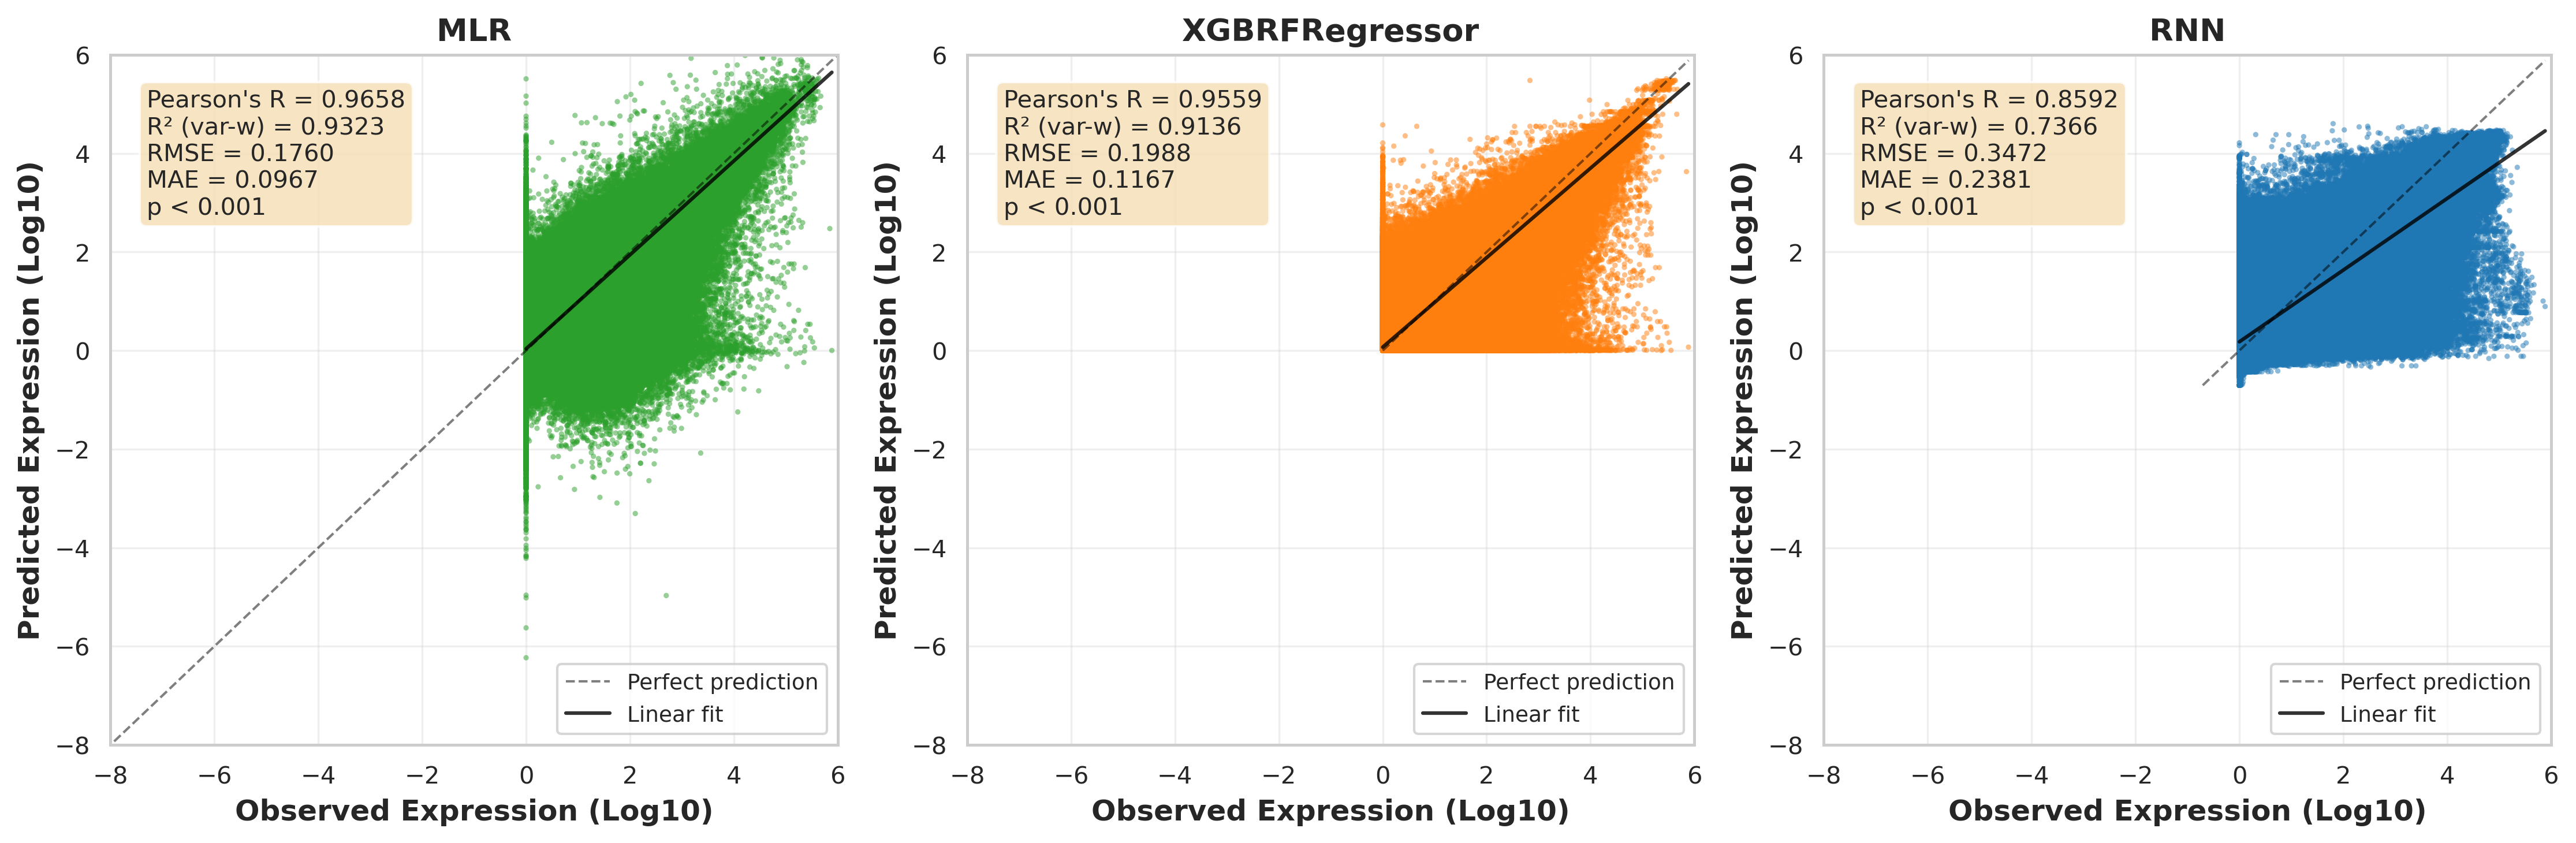

In [9]:
############### PLOTTING STEP ###############

figure_1_observed_vs_predicted(y_test,predictions_test,r2_method='variance_weighted', output_path = '/home/christianl/Zhang-Lab/Zhang Lab Data/Saved figures/Production_model_figures/figure1_(PRODUCTION.v4)).png')